# name: Marco Giunta
## Rlab04

In [1]:
library(tidyverse)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



# Exercise 1: six boxes toy model - inference (i.e. with user input)
**Theoretical details**                

This exercise is a straightforward application of the Bayes theorem in the context of Bayesian inference.     
We know Bayes theorem can be expressed in words as follows:
\begin{equation}
  \text{posterior} = \frac{\text{likelihood}\times{\text{prior}}}{\text{evidence}}
\end{equation}
which can be made a bit more explicit as follows:
\begin{equation}
  p(\text{model}_i|\text{data}) = \frac{p(\text{data}|\text{model}_i) p(\text{model}_i)}{p(\text{data})} \quad \text{where} \ p(\text{data}) = \sum_i p(\text{data}|\text{model}_i) p(\text{model}_i)
\end{equation}

The above equations are fully general in the sense that $\text{model}_i$ is a set of parameters of an abstract model, whereas $\text{data}$ refers to a (potentially multi-dimensional) outcome of a generic experiment; how do these translate in our six boxes experiment? 
1) *Model*: The hypotesis wrt which we carry out the inference is simply the content of the box picked at the beginning of the experiment, starting from the 6 possible ones. This means that the model is fully parametrized by the index $i$ of the box i.e. by the number of white beads inside the box; hence we have a 1-D inference of this single parameter.     
2) *Data*: In the six boxes experiment we extract one bead at a time by picking it at random (with replacement) from the box. Since at each time step we extract a single bead "data" in our case simply means the color of the extracted stone, i.e. "white" or "black". This means that any given extraction/event $E$ can be parametrized by $k = \text{white}/\text{black}$; our inference is completely 1-D, then, and no marginalization will be needed. 

These two bullet points help us rewrite Bayes theorem in a fully mathematical way as follows. Let $H_i$ be the hypothesis "the box contains $i$ white beads", $E_k$ the event "a bead with color $k$ was sampled from the box" (where $K$ is either black or white), and $I$ the previously available information (made available to us by e.g. previous runs of the same experiment with the same box). Then Bayes' theorem becomes:
\begin{equation}
p(H_i|E_k I) = \frac{p(E_k|H_i I)p(H_i|I)}{p(E_K|I)}
\end{equation}
Notice that the prior ($p(H_i|I)$) and the posterior ($p(H_i|E_k I)$) are *discrete probability distributions over the space of the 6 possible boxes/values of $i$*, and hence can be represented by a 6-components vector; hence we need to create 2 vectors such that each component represents the probability that the box actually contains  $i$ white beads. Of course since we repeat the experiment multiple times we can use an iterative procedure, such that each computed posterior becomes the next iteration's prior; this means that we only need to construct the original prior ("prior 0" for short) and an algorithm to take a prior into the appropriate posterior using the extracted color in the likelihood.       
1) *Prior 0*: it suffices to say that at the beginning of the experiment we know nothing about the procedure with which the box was selected, and hence it's appropriate to choose the least informative prior i.e. the uniform one. A similar conclusion is reached if we know that between the 6 possible boxes one is picked completely at random (for example by throwing a fair dice); a different prior 0 is needed only if we know some extra nontrivial piece of information (e.g. if we know the box was picked by throwing a rigged dice), but the choice of the prior won't matter too much as long as we repeat the experiment a sufficiently large number of times.
2) *Algorithmic implementation of Bayes' theorem*: Now we need to compute the likelihood function, which requires us to discuss the generative model appropriate to this problem.
Let's say we know for sure box $i$ was selected; then the probability of picking a white bead is $i/5$, because this is the ratio of white beads to total number of beads (box 0 will have $p_w=0$ of getting any white bead, box 1 will have $p_w=1/5$, and so on up to box 5 which of course has $p_w = 1$). If we now fix the extracted color and consider this probability distribution as a function of the model we obtain our likelihood (which is *no longer a probability distribution*, since it's normalized wrt the "wrong" argument).         

Point 2 means that (since there are only 2 colors) the likelihood function is:
\begin{equation}
  p(E_k|H_i I) = \left\{
    \begin{array}
      \ i/5 \qquad \text{if $k$ = white}\\
      \ 1-i/5 \  \text{if $k$ = black}
    \end{array} 
  \right.
\end{equation}
These two distinct cases can be unified if we switch to a different representation: if we map $k\in [\text{w},\text{b}] \to j\in [0,1]$ then we can rewrite our likelihood as follows:
\begin{equation}
  p(E_j|H_i I) = |j - i/5|
\end{equation}
because if $j=0$ (white bead) this correctly equals $i/5$, whereas if $j=1$ (black bead) this (again correctly) equals $1-i/5$, since $1-i/5$ is never negative.    
*Notice that this is a function of $i$ only since $j$ is fixed by the outcome of the experiment, whereas $i$ is what we're unsure about and trying to infer from the data*.                

Finally we notice that since $i$ only takes on 6 possible discrete values this function can once again be represented as a 6d vector; by summing this vector's components times the priors' (elementwise product) we obtain the evidence, which is simply the L1 norm of the likelihood $\times$ prior term (and ensures that the posterior is normalized wrt L1 norm, as any prob. dist. should be).
Indeed exploiting the fact that the $H_i$ define a partition of sample space we have that
\begin{equation}
  p(E_j|I) = \sum_{i=0}^5 p(E_h|H_i I)p(H_i|I) \in \mathbb{R}
\end{equation}
which is the L1 norm of the aforementioned elementwise product.

**Technical details**         
*Helper functions*:
1) We define a `compute.posterior` function, which takes a `prior` and a `data` (0 or 1) arguments and computes the likelihood, the evidence and the prior according to the above equations; then the posterior is returned.
2) We define a `get.user.input` function, whose purpose is to read from prompt and parse the input given by the user. If the user types "w" or "b" respectively then the first output of this function will be either 0 or 1, and its second output will be a boolean variable set equal to TRUE; if the input is any other string the numeric output will be NA, but if it is "stop" in particular the boolean variable will be set equal to FALSE.
3) We define a `plot.posterior` function, which converts the posterior to `data.frame` and plots it using `ggplot2`.

*Main algorithm*:        
We define prior 0 as a 6d vector with components equal to 1/6, a `proceed` variable set equal to TRUE and initiate a `while` loop which goes on until `proceed` becomes equal to FALSE. Inside this loop we obtain the parsed user input, which is used to compute $j$ and to update `proceed` if the user typed "stop"; every time we're able to compute a valid posterior (i.e. every time $j$ is not NA) we store the newly obtained posterior as a new row in a dataframe, which is useful to a) construct the inference's history as we go along the experiment, and b) implement the iterative procedure outlined above: if $j$ is not NA then we use the last row as the prior, and add the resulting posterior as the new last row.      
Finally if the `plot.check` boolean variable is set equal to TRUE we plot the running posterior before moving on to the next iteration. Notice that this variable is FALSE by default because I can't make Jupyter plot the correct posterior at the correct `while` iteration; the first couple of plots don't show up until two iterations later, which is *not* the intended behaviour. I'm not sure why this happens (a bug in my version of Jupyter? A silly mistake on my part?), but I know that this does *not* happen by executing the very same code as a `.r` script instead of as an `.ipynb` notebook. This is why I'm a) leaving `plot.check` equal to FALSE by default (but feel free to switch it and see what happens), and b) including `boxes1.R`, which contains the same code but when executed in the terminal works smoothly.

In [2]:
compute.posterior <- function(prior, data) { # Bayes' theorem
    likelihood <- abs(data - 0:5/5)
    likelihood.times.prior <- likelihood*prior
    evidence <- sum(likelihood.times.prior)
    posterior <- likelihood.times.prior/evidence
    return (posterior)
}

In [3]:
get.user.input <- function() {
    input <- readline(prompt = 'enter extracted color ("w" or "b") or "stop" ')
    if (input == "w") x <- 0
    else {
        if (input == "b") x <- 1
        else x <- NA
    }
    if (input == "stop") proceed <- FALSE
    else proceed <- TRUE
    
    return (c(x, proceed)) # R doesn't seem to support multiple returns, instead requiring the user work with vectors only
}

In [4]:
plot.posterior <- function(posterior, index) {
    df.ggplot <- data.frame(0:5, posterior) # helper dataframe to feed ggplot2 with
    names(df.ggplot) <- c("hypothesis", "posterior")
    ggplot(data = df.ggplot, aes(x = hypothesis, y = posterior)) + geom_point() + geom_line() + ggtitle(sprintf("Extraction n. %d", index))
}

enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
        H0         H1         H2         H3         H4         H5 
0.33333333 0.26666667 0.20000000 0.13333333 0.06666667 0.00000000 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
        H0         H1         H2         H3         H4         H5 
0.45454545 0.29090909 0.16363636 0.07272727 0.01818182 0.00000000 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
         H0          H1          H2          H3          H4          H5 
0.555555556 0.284444444 0.120000000 0.035555556 0.004444444 0.000000000 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
        H0         H1         H2         H3         H4         H5 
0.63840654 0.26149132 0.08273749 0.01634321 0.00102145 0.00000000 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
          H0           H1           H2           H3           H4           H5 
0.7062146893 0.2314124294 0.0549152542 0.0072316384 0.0002259887 0.0000000000 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
          H0           H1           H2           H3           H4           H5 
7.616378e-01 1.996588e-01 3.553497e-02 3.119669e-03 4.874482e-05 0.000000e+00 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
          H0           H1           H2           H3           H4           H5 
8.068681e-01 1.692125e-01 2.258714e-02 1.321973e-03 1.032791e-05 0.000000e+00 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
          H0           H1           H2           H3           H4           H5 
8.437208e-01 1.415529e-01 1.417127e-02 5.529408e-04 2.159925e-06 0.000000e+00 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
          H0           H1           H2           H3           H4           H5 
8.736997e-01 1.172660e-01 8.804880e-03 2.290351e-04 4.473342e-07 0.000000e+00 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
          H0           H1           H2           H3           H4           H5 
8.980484e-01 9.642721e-02 5.430155e-03 9.416720e-05 9.196015e-08 0.000000e+00 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
          H0           H1           H2           H3           H4           H5 
9.177939e-01 7.883789e-02 3.329729e-03 3.849506e-05 1.879642e-08 0.000000e+00 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
          H0           H1           H2           H3           H4           H5 
9.337826e-01 6.416905e-02 2.032642e-03 1.566627e-05 3.824774e-09 0.000000e+00 


enter extracted color ("w" or "b") or "stop"  b


[1] "running posterior:"
          H0           H1           H2           H3           H4           H5 
9.467112e-01 5.204600e-02 1.236471e-03 6.353271e-06 7.755458e-10 0.000000e+00 


enter extracted color ("w" or "b") or "stop"  w


[1] "running posterior:"
          H0           H1           H2           H3           H4           H5 
0.000000e+00 9.543070e-01 4.534345e-02 3.494777e-04 5.688113e-08 0.000000e+00 


enter extracted color ("w" or "b") or "stop"  stop


[1] "Inference history:"


,E,H0,H1,H2,H3,H4,H5
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NA,0.1666667,0.16666667,0.166666667,1.666667e-01,1.666667e-01,0.1666667
2,B,0.3333333,0.26666667,0.200000000,1.333333e-01,6.666667e-02,0.0000000
3,B,0.4545455,0.29090909,0.163636364,7.272727e-02,1.818182e-02,0.0000000
4,B,0.5555556,0.28444444,0.120000000,3.555556e-02,4.444444e-03,0.0000000
5,B,0.6384065,0.26149132,0.082737487,1.634321e-02,1.021450e-03,0.0000000
6,B,0.7062147,0.23141243,0.054915254,7.231638e-03,2.259887e-04,0.0000000
7,B,0.7616378,0.19965879,0.035534974,3.119669e-03,4.874482e-05,0.0000000
8,B,0.8068681,0.16921250,0.022587142,1.321973e-03,1.032791e-05,0.0000000
9,B,0.8437208,0.14155286,0.014171269,5.529408e-04,2.159925e-06,0.0000000


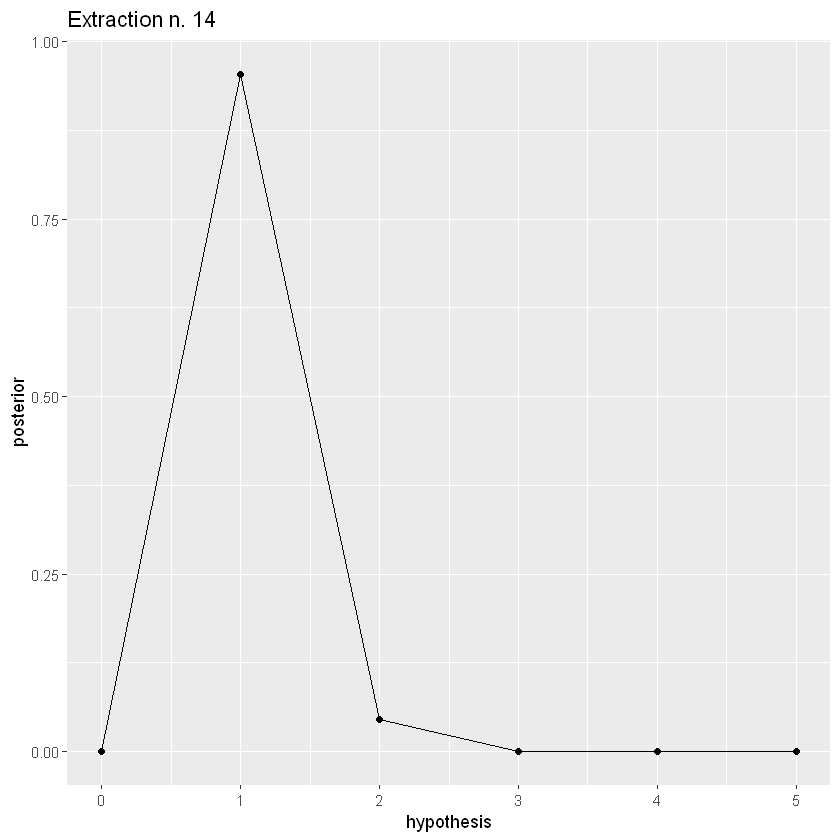

In [5]:
plot.check <- FALSE #TRUE

proceed <- TRUE
prior <- rep(1, times = 6)/6 # prior 0: the least informative one

df <- data.frame(matrix(0, nrow = 1, ncol = 6)) # the datframe that stores the result of the inference as we go
for (i in 0:5) names(df)[i+1] <- sprintf("H%d",i)  # 6 columns, one for the prob. of each box
df[1,] <- prior # the first row contains prior 0, of course
extracted.colors.history <- c(NA) # df only contains the 6d vctors representing the posteriors, but in order to pretty print a report of the inference once it ends it's useful to store what the user typed.
# The first component of this vector should be NA, of course, since the user typed nothing to obtain prior 0 since *by definition* this represents the state of our knowledge *before* seeing any data.

while (proceed) {
    v <- get.user.input() # tmp vector
    extracted.color <- v[1]; proceed <- v[2]
    if (!is.na(extracted.color)) { # if j is NA we skip this iteration; if this was due to a mistake the user has a new chance to type a valid value, if it was because "stop" was typed then the next while iteration ends
        prior <- unlist(tail(df, 1)) # running prior = last df row
        posterior <- compute.posterior(prior, data = extracted.color) # this and the previous lines could have been unified e.g. with %>%, but I'd rather make everything clearer
        
        new.row.index <- length(unlist(df[1]))+1 # this is the index of the new row, representing the freshly computed posterior
        df[new.row.index,] <- posterior
        print("running posterior:")
        print(posterior); flush.console() # this is necessary since otherwise the print is ignored
        extracted.colors.history[new.row.index] <- extracted.color # we store this iteration's j value
        if (plot.check) print(plot.posterior(posterior, new.row.index-1)) # https://stackoverflow.com/questions/15678261/ggplot-does-not-work-if-it-is-inside-a-for-loop-although-it-works-outside-of-it
    }
}

event.col <- rep(NA, times = new.row.index) # df only contains the posteriors; we create a new dataframe column containing the extracted colors history
event.col[extracted.colors.history == 1] = "B" # these two lines convert j = 0,1 back to k = "w","b"
event.col[extracted.colors.history == 0] = "W" # we use logical masking, but other alternatives are possible e.g. filter

print("Inference history:")
cbind(E = event.col, df) # this dataframe is simply df + the colors history as the leftmost column
plot.posterior(posterior, new.row.index-1) # this plots the final posterior

# Exercise 2: six boxes toy model - simulation (i.e. no user input)
Here most code is recycled from exercise 1, of course; the only different is that the user input is replaced with a simulation.        
1) First we `sample` a number between 0 and 5 to serve as the (unkown) number of white beads inside the simulated box ($i$), and print this to standard output.
2) Next we define a `rbox` function to the simulate the act of randomly selecting a bead from the box. There are multiple ways to do this; for example we could create the discrete counterpart of the uniform distribution, where values of $j$ equal to 0 and 1 have $p$ equal to $i/5$ and to $1-i/5$, respectively - but I find it easier to actually simulate what we would physically do. This means we create a `box` vector containing $i$ zeros (i.e. $i$ white beads) and $5 - i$ ones (i.e. black beads), then sample one element of this vector at random exactly as we would randomly pick a bead from the box were we to physically carry out the inference process.    

Everything else works the same way; the only difference is that no while loop is needed, since we specify the number of iterations at the beginning and simply use a for loop.

Once again Jupyter notebooks and plots inside loops don't play nicely (set `plot.check` equal to TRUE to check it for yourself), but the very same code in the `boxes2.R` script works as intended (try that, too).

[1] "The unknown box contains 3 white balls and 2 black balls (hypothesis H3)"
[1] "Simulating 10 draws"
[1] "white ball extracted"
[1] "white ball extracted"
[1] "black ball extracted"
[1] "black ball extracted"
[1] "white ball extracted"
[1] "white ball extracted"
[1] "white ball extracted"
[1] "white ball extracted"
[1] "black ball extracted"
[1] "white ball extracted"
[1] "Inference history:"


,E,H0,H1,H2,H3,H4,H5
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,NA,0.1666667,0.166666667,0.16666667,0.1666667,0.1666667,0.1666667
2,W,0.0000000,0.066666667,0.13333333,0.2000000,0.2666667,0.3333333
3,W,0.0000000,0.018181818,0.07272727,0.1636364,0.2909091,0.4545455
4,B,0.0000000,0.080000000,0.24000000,0.3600000,0.3200000,0.0000000
5,B,0.0000000,0.153846154,0.34615385,0.3461538,0.1538462,0.0000000
6,W,0.0000000,0.061538462,0.27692308,0.4153846,0.2461538,0.0000000
7,W,0.0000000,0.021621622,0.19459459,0.4378378,0.3459459,0.0000000
8,W,0.0000000,0.006956522,0.12521739,0.4226087,0.4452174,0.0000000
9,W,0.0000000,0.002104156,0.07574961,0.3834824,0.5386639,0.0000000


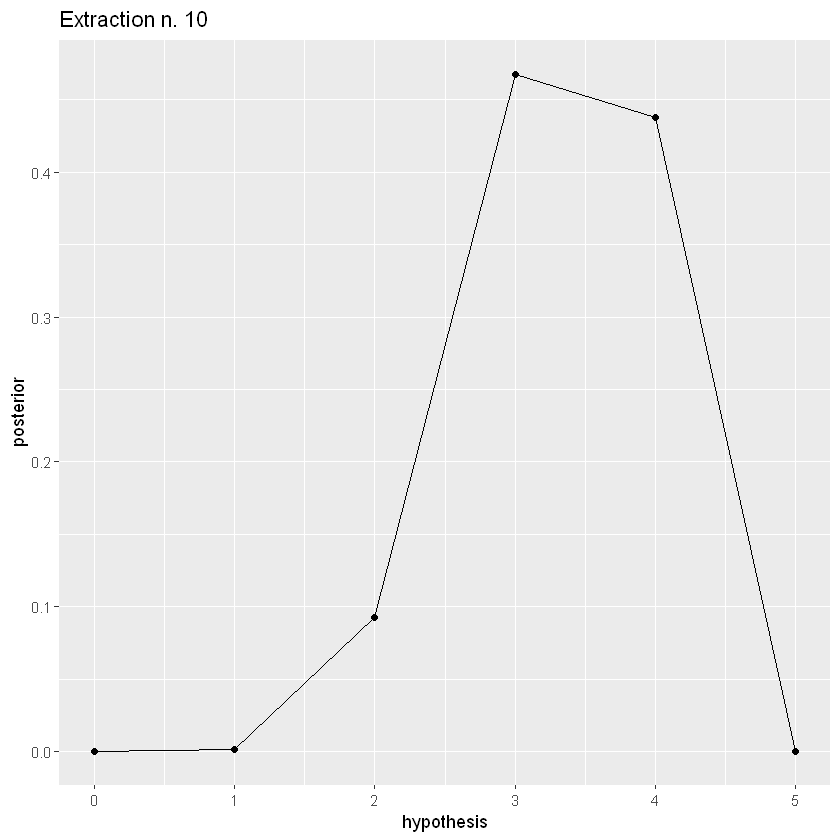

In [6]:
set.seed(1234)

n.white <- sample(0:5)[1] # this returns an integer in [0,5] at random
print(sprintf("The unknown box contains %d white balls and %d black balls (hypothesis H%d)", n.white, (5-n.white), n.white))

box <- c(rep(0, times = n.white), rep(1, times = 5-n.white))
rbox <- function(box) sample(box)[1] # this picks a bead at random by randomly sampling one of box's components

colors.array <- c("white", "black") # this is useful to convert j (int) to k (chr)

prior <- rep(1, times = 6)/6 # prior 0
df <- data.frame(matrix(0, nrow = 1, ncol = 6)) # running posteriors dataframe
for (i in 0:5) names(df)[i+1] <- sprintf("H%d",i) 
df[1,] <- prior

verbose <- FALSE # set this to TRUE to print prior 0 and the running posterior. FALSE by default since this is not as interesting as in the user-input version; here the final result of the simulation matters more
plot.check <- FALSE

n.draws <- 10
print(sprintf("Simulating %d draws", n.draws))
if (verbose) {
    print("prior:")
    print(prior)
} 

extracted.colors.history <- c(NA) # same as before

for (i in 1:10) {
    extracted.color <- rbox(box)
    extracted.colors.history[i+1] <- extracted.color
    print(sprintf("%s ball extracted", colors.array[extracted.color+1])) # if j=0 then we print colors.array[1], whereas if j=1 we print colors.array[2]
    
    prior <- unlist(tail(df, 1)) # running prior = last df row
    posterior <- compute.posterior(prior, data = extracted.color)
    df[length(unlist(df[1]))+1,] <- posterior
    
    if (plot.check) print(plot.posterior(posterior, i))
    
    if (verbose) {
        print("running posterior:")
        print(posterior)
    }
}

event.col <- rep(NA, times = length(extracted.colors.history))
event.col[extracted.colors.history == 1] = "B"
event.col[extracted.colors.history == 0] = "W"

print("Inference history:")
cbind(E = event.col, df)

plot.posterior(posterior, n.draws) # plot the last computed posterior

# Exercise 3: sampling from the Erlang distribution
There are multiple ways to do this, of which I list 3:
- we can use the `rgamma` base R function, since the Erlang distribution is just a special case of the Gamma one;
- we can use general-purpose algorithms, like inverse sampling or rejection sampling;
- we can exploit the reproductive property.      

The last option simply means that if $u_i \sim U(]0,1]), \ i = 1,\dots,k$ and we want to compute $x \sim E(k,\lambda)$ then it suffices to use the following formula (cfr [here](https://en.wikipedia.org/wiki/Erlang_distribution)):
\begin{equation}
  x = -\frac{1}{\lambda} \sum_{i=1}^k \ln u_i
\end{equation}
where $k$ and $\lambda$ are the Erlang distribution *shape* and *rate* parameters, respectively.

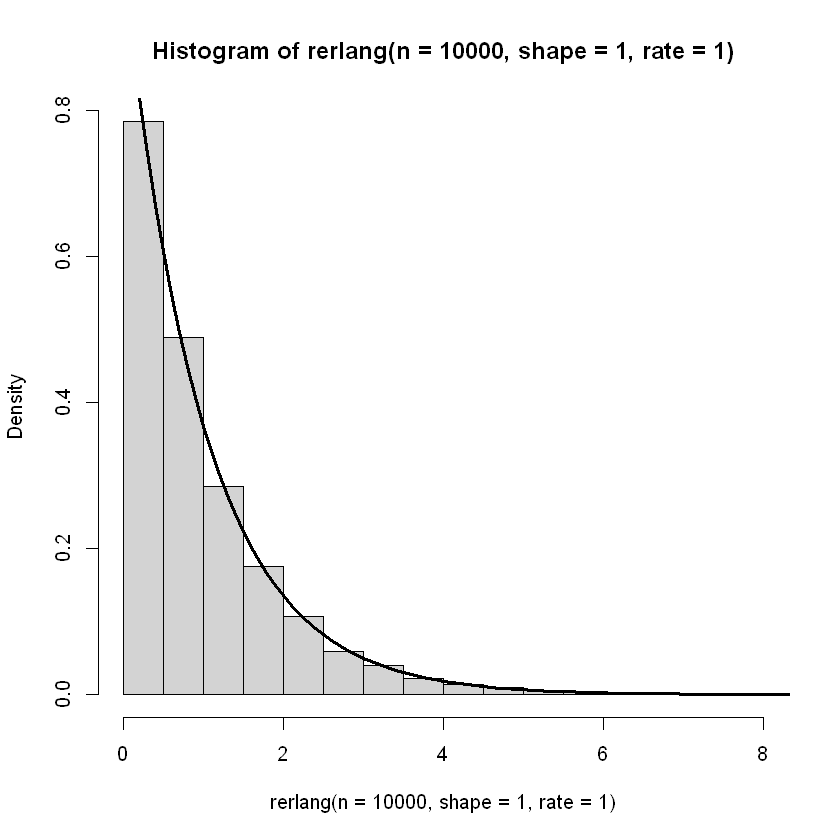

In [7]:
rerlang <- function(n, shape, rate) {
    x <- rep(0, times = n) # each of the n components of x (i.e. each of the n numbers we want to sample) requires a sum over shape numbers
    for (i in 1:n) x[i] <- -1/rate*sum(log(runif(shape))) # a faster, vectorized implementation would consist in generating shape*n uniform samples and summing them in groups of shape size. This is easier, though!
    return (x)
}


# To check this works we sample a bunch of numbers and compare the histogram with the PDF
perlang <- function(x, shape, rate) return (rate^shape*x^(shape-1)*exp(-rate*x)/factorial(k-1)) # cfr Wikipedia, same link as above
perlang11 <- function(x) return (perlang(x, 1, 1))

k <- 1; lambda <- 1
#hist(rerlang(100000, shape = k, rate = lambda), freq = FALSE)
hist(rerlang(n = 10000, shape = 1, rate = 1), freq = FALSE)
curve(perlang11, from = 0, to = 10, add = TRUE, lwd = 3)

# Exercise 4: Middle square Von Neumann algorithm
**Algorithm**: to generate random number according to this method we proceed as follows. 
- First we choose a *seed* (the first number of the pseudorandom sequence, which is an input to the algorithm) made up of $n$ digits - where *$n$ must be an even number*; 
- then we square it to obtain a number with $2n$ digits (if there are less than $2n$ digits we pad it with leading zeros);
- then we keep the $n$ digits in the middle, and the result is a) a member of the pseudorandom sequence and b) the seed of the following algorithm iteration.     

There above procedure is made nontrivial only by the fact that numbers can't be indexed like vectors. How can we pick individual digits from an integer input, then? There are at least two ways. 
- *Approach 1*: we cheat! We cast our input to `character` (using `as.character`), then split it to a list containing individual characters i.e. digits (using `strsplit`), then cast this list to vector type (using `unlist`). Now we can easily remove the first and the last $n/2$ elements; it suffices to index this vector with `-c((1:n/2),((3*n/2)+1):(2*n))`, since this means we're removing elements `1:n/2` and elements `(n/2+n+1):(2*n)` (which we do in order to keep `n` elements between the leading and trailing `n/2`, i.e. the `n` elements following the first `n/2`). Also notice that we guarantee our vector has $2n$ elements by zero-padding it at the beginning if needed.
- *Approach 2*: we exploit the decimal number system. Let's say $x = 12345$; if we divide and multiply $x$ by $100$ nothing changes, of course, but if before multiplying by $100$ again we remove the decimal part (using `floor`) then we will obtain $\texttt{floor}(123.45)*100 = 123*100 = 12300$ - and hence we successfully removed the last 2 digits! This explains how we can remove the last $n/2$ digits, but what about the first ones? It suffices to recycle the same strategy as follows. Let's say we want to keep the last $d$ digits of an integer number; if we remove them using the above method, then multiply the result by $10^d$, then subtract this from the original number then we're done. Example: say $x=12345$ and $d=3$. By removing the last $d$ digits we obtain $12$, which multiplied by $10^d$ equals $12000$; now since $12345 - 12000 = 345$ we're done.    


Approach #2 is better because a) it doesn't involve lists and conversions back and forth to `chr`, which means it's potentially faster, and b) it removes the need to check for missing digits and zero-padding if needed (since we're just moving the floating point by a set number of places, independently of number "length"). These advantages come at the expense of a conceptually more complicated method (approach #1 replicates what a human would do to manually implement the Von Neumann algorithm); hence I'm implementing them both.

In [8]:
# First let's write some utility functions. In the above cell we already explained that strsplit(as.character(x), "") returns a list of characters such that each element is one of x's digits; if we unlist this we obtain a vector,
# whose length is easily computed. To reverse this operation (i.e. to go from a vector of characters to a number made up of those digits) it suffices to concatenate the chr array into a single chr (using paste) and then
# cast to num type using as.numeric

length.digits             <- function(x) return (length(unlist(strsplit(as.character(x), ""))))
as.chr.vector             <- function(x) return (unlist(strsplit(as.character(x), "")))
as.num.vec.from.chr.array <- function(x) return (as.numeric(paste(x, collapse = "")))

middle.square.generator <- function(N, seed = 1234) {
    x <- seed
    n <- length.digits(x) # this is the n that decides how many digits to drop/keep
    output <- rep(NA, times = N)
    for (i in 1:N) {
        y <- as.chr.vector(x^2) # the digits of x^2
        l <- length(y)
        if (l < 2*n) z <- c(rep("0", times = (2*n-l)), y) # if x^2 doesn't have 2n digits we add enough zeros at the beginning
        else z <- y # otherwise we don't modify it
        a <- as.num.vec.from.chr.array(z[-c((1:n/2), ((3*n/2)+1):(2*n))]) # now we remove the unwanted digits (see cell above for an explanation of these numbers) and reassemble the integer number
        output[i] <- a
        x <- a # the output we just computed is used as the seed of the next algorithm iteration
    }
    return (output)
}

print(middle.square.generator(10))

 [1] 5227 3215 3362 3030 1809 2724 4201 6484  422 1780


In [9]:
# Once again we first write some utility functions. As explained above the appropriate multiplication/division by 10^some.number can be used to discard unwanted leading/trailing digits, so it should be pretty clear
# what the following functions do. Notice that to properly discard digits after a number's floating point we need to use floor, since this function returns the largest integer not larger than its argument
# (which is exactly what we need; removing the decimal part returns exactly this integer). This is important because functions like round, trunc, ceiling do slightly different things and hence may introduce bugs

remove.last.n.digits.from.integer <- function(x, n.digits) return (floor(x/10^n.digits)) # floor = largest int not greater than argument (avoid ceiling, round or trunc)
keep.last.n.digits.of.integer     <- function(x, n.digits) {
    a <- remove.last.n.digits.from.integer(x, n.digits)*10^n.digits
    return (x-a)
}

middle.square.generator.numeric <- function(N, seed = 1234) {
    x <- seed 
    n <- length.digits(x) # as before this is the n mentioned in the "theoretical" algorithm explanation
    output <- rep(NA, times = N)
    for (i in 1:N) {   
       output[i] <- remove.last.n.digits.from.integer(x^2, n.digits = n/2) %>% keep.last.n.digits.of.integer(n.digits = n) # we discard the last n/2 digits, then keep the last n ones
       x <- output[i] # once again: the output of iteration i is the seed for iteration i+1
    }
    return (output)
}

print(middle.square.generator.numeric(10))
print(middle.square.generator(10) == middle.square.generator.numeric(10)) # a check to compare the 2 functions

 [1] 5227 3215 3362 3030 1809 2724 4201 6484  422 1780
 [1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
